# CarND Vehicle Detection Project

## Project Goals
In this project, the goal is to write a software pipeline to detect vehicles in a video. The goals/steps of this project are the following:
- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, we can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector
- Note: for those first two steps don't forget to normalize the features and randomize a selection for training and testing
- Implement a sliding-window technique and use our trained classifier to search for vehicles in images
- Run our pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles
- Estimate a bounding box for vehicles detected

## Data Collection
Collect the images from the training data folder.

In [1]:
import time
import glob
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from collections import deque
from moviepy.editor import VideoFileClip

%matplotlib inline

# A helper class to collect all the images from the traning data
class DataCollector:
    def __init__(self, training_data_directory):
        self.training_data_directory = training_data_directory
        self.cars = []
        self.noncars = []
    
    # Get one of the images of the cars
    def get_image_of_car(self, index):
        return mpimg.imread(self.cars[index])
    
    # Get one of the images of the objects that are not cars
    def get_image_of_noncar(self, index):
        return mpimg.imread(self.noncars[index])
    
    # Collect the images from the training data
    def collect_training_data(self):
        image_files = glob.glob(self.training_data_directory + '/*/*/*.png')
        car_image_files = []
        noncar_image_files = []
        
        for image_file in image_files:
            if ('non-vehicles' in image_file):
                noncar_image_files.append(image_file)
            else:
                car_image_files.append(image_file)
        
        # Get only 1/5 of the training data to avoid overfitting
        for index, noncar_image_file in enumerate(noncar_image_files):
            if (index % 5 == 0):
                self.noncars.append(noncar_image_file)
        
        for index, car_image_file in enumerate(car_image_files):
            if (index % 5 == 0):
                self.cars.append(car_image_file)
    
    # Show a comparison between a image of a car and a image of a non-car object
    def show_image_comparison(self, car_image, noncar_image):
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title("Image of Car")
        plt.imshow(car_image)
        
        plt.subplot(1, 2, 2)
        plt.title("Image of Non-Car")
        plt.imshow(noncar_image)
        plt.show()

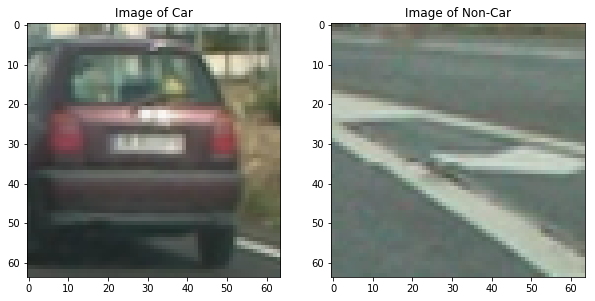

In [2]:
# Test the DataCollector class
data_collector = DataCollector('./training-data')
data_collector.collect_training_data()

image_index = 89
car_image = data_collector.get_image_of_car(image_index)
noncar_image = data_collector.get_image_of_noncar(image_index)
data_collector.show_image_comparison(car_image, noncar_image)

## Feature Extraction

In [3]:
# A helper class to hold the HOG feature extraction parameters
class HOGFeatureExtractionParameters:
    def __init__(self):
        ######## HOG Features ########
        # HOG features on or off
        self.feature_on = True
        
        # HOG orientations
        self.orientations = 15
        
        # HOG pixels per cell
        self.pix_per_cell = 8
        
        # HOG cells per block
        self.cell_per_block = 2
        
        # HOG visualise image
        self.visualise = False
        
        # HOG channel, can be 0, 1, 2, or "ALL"
        self.channel = "ALL"

# A helper class to hold the Spatial feature extraction parameters
class SpatialFeatureExtractionParameters:
    def __init__(self):
        # Spatial features on or off
        self.feature_on = True
        
        # Spatial binning dimensions
        self.size = (32, 32)

# A helper class to hold the Histogram feature extraction parameters
class HistogramFeatureExtractionParameters:
    def __init__(self):
        # Histogram features on or off
        self.feature_on = True
        
        # Number of histogram bins
        self.bins = 32

# A helper class to hold the feature extraction parameters
class FeatureExtractionParameters:
    def __init__(self):
        self.hog = HOGFeatureExtractionParameters()
        self.spatial = SpatialFeatureExtractionParameters()
        self.histogram = HistogramFeatureExtractionParameters()

# A helper class to extract features from images
class FeatureExtractor:
    def __init__(self):
        self.parameters = FeatureExtractionParameters()
        
        # The color space can be RGB, HSV, LUV, HLS, YUV, or YCrCb
        self.color_space_for_extraction = 'YUV'
    
    # Extract features from a list of images
    def extract_features(self, image_files):
        # Create a list to append feature vectors to
        features = []
        
        # Extract features from each image in the list
        for image_file in image_files:
            image = mpimg.imread(image_file)
            image_features = self.extract_features_from_image(image)
            features.append(np.concatenate(image_features))
        
        return features
    
    def extract_features_from_image(self, image):     
        feature_image = self.convert_color(image, self.color_space_for_extraction)
        file_features = []
        if (self.parameters.spatial.feature_on):
            spatial_features = self.get_spatial_image(feature_image)
            file_features.append(spatial_features)
        
        if (self.parameters.histogram.feature_on):
            # Extract color histogram feature
            hist_features = self.get_color_histogram(feature_image)
            file_features.append(hist_features)
        
        if (self.parameters.hog.feature_on):
            # Extract HOG feature
            if (self.parameters.hog.channel == 'ALL'):
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(self.get_hog_features(feature_image[:, :, channel], \
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = self.get_hog_features(feature_image[:, :, self.parameters.hog.channel], \
                                                     vis=False, feature_vec=True)
            
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        return file_features
    
    # Convert the orginial image to another color space image
    def convert_color(self, orginial_image, destination_color_space='RGB'):
        if (destination_color_space == 'RGB'):
            destination_image = np.copy(orginial_image) 
        elif destination_color_space == 'HSV':
            destination_image = cv2.cvtColor(orginial_image, cv2.COLOR_RGB2HSV)
        elif destination_color_space == 'LUV':
            destination_image = cv2.cvtColor(orginial_image, cv2.COLOR_RGB2LUV)
        elif destination_color_space == 'HLS':
            destination_image = cv2.cvtColor(orginial_image, cv2.COLOR_RGB2HLS)
        elif destination_color_space == 'YUV':
            destination_image = cv2.cvtColor(orginial_image, cv2.COLOR_RGB2YUV)
        elif destination_color_space == 'YCrCb':
            destination_image = cv2.cvtColor(orginial_image, cv2.COLOR_RGB2YCrCb)
        
        return destination_image
    
    # Get the HOG features of a image
    def get_hog_features(self, image, vis=False, feature_vec=True):
        if (vis):
            # Call with two outputs if vis is True
            features, hog_image = hog(image, orientations=self.parameters.hog.orientations, \
                                      pixels_per_cell=(self.parameters.hog.pix_per_cell, \
                                                       self.parameters.hog.pix_per_cell), \
                                      cells_per_block=(self.parameters.hog.cell_per_block, \
                                                       self.parameters.hog.cell_per_block), \
                                      transform_sqrt=False, visualise=vis, \
                                      feature_vector=feature_vec)
            return features, hog_image
        else:
            # Call with one output
            features = hog(image, orientations=self.parameters.hog.orientations, \
                           pixels_per_cell=(self.parameters.hog.pix_per_cell, \
                                            self.parameters.hog.pix_per_cell), \
                           cells_per_block=(self.parameters.hog.cell_per_block, \
                                            self.parameters.hog.cell_per_block), \
                           transform_sqrt=False, visualise=vis, \
                           feature_vector=feature_vec)
            return features
    
    # Get the spatial image from the original image
    def get_spatial_image(self, image):
        channel_0_image = cv2.resize(image[:, :, 0], self.parameters.spatial.size).ravel()
        channel_1_image = cv2.resize(image[:, :, 1], self.parameters.spatial.size).ravel()
        channel_2_image = cv2.resize(image[:, :, 2], self.parameters.spatial.size).ravel()
        return np.hstack((channel_0_image, channel_1_image, channel_2_image))
    
    # Get the histograms of the color channels separately from a image
    def get_color_histogram(self, image):
        # Compute the histogram of the color channels separately
        channel_0_histogram = np.histogram(image[:, :, 0], bins=self.parameters.histogram.bins)
        channel_1_histogram = np.histogram(image[:, :, 1], bins=self.parameters.histogram.bins)
        channel_2_histogram = np.histogram(image[:, :, 2], bins=self.parameters.histogram.bins)
        
        # Concatenate the histograms into a single feature vector
        histogram_features = np.concatenate((channel_0_histogram[0], channel_1_histogram[0], channel_2_histogram[0]))
        return histogram_features
    
    # Show a list of images with titles
    def show_images_with_titles(self, images_with_titles):
        image_count = len(images_with_titles)
        f, axes = plt.subplots(1, image_count, figsize=(24, 9))
        f.tight_layout()
        for index in range(image_count):
            axes[index].imshow(images_with_titles[index]['image'], cmap='gray')
            axes[index].set_title(images_with_titles[index]['title'], fontsize=20)
        
        plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.0)

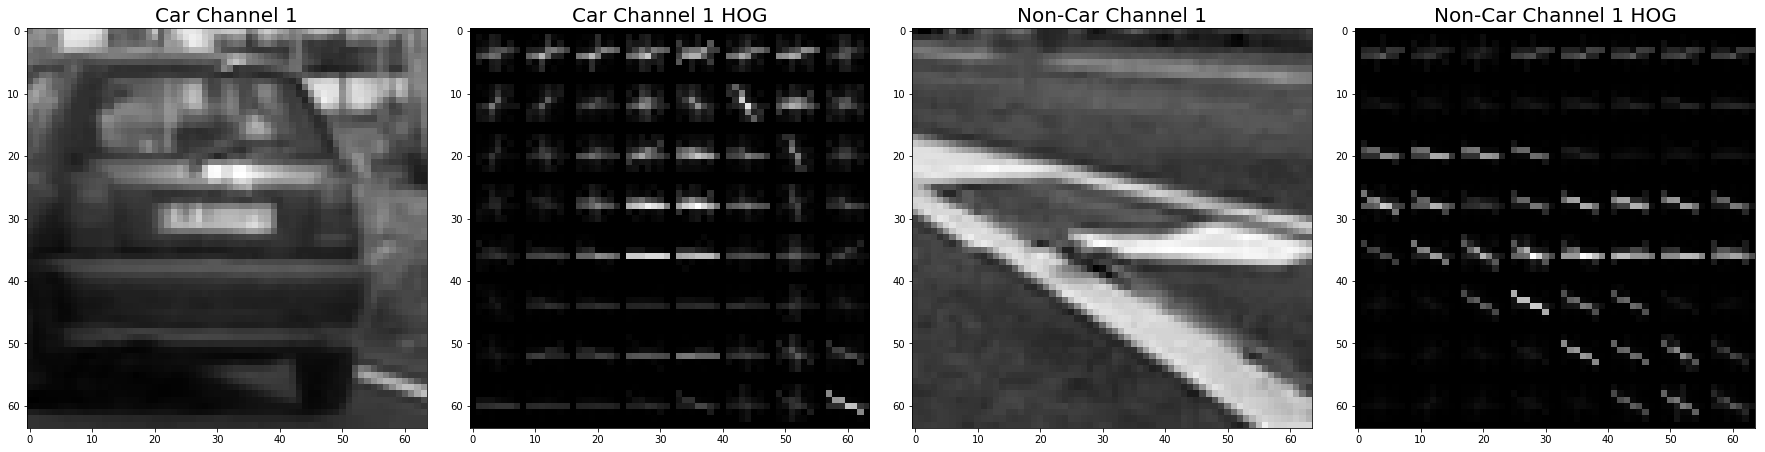

In [4]:
# Test the FeatureExtractor class
feature_extractor = FeatureExtractor()

YUV_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
car_ch1 = YUV_car_image[:, :, 0]
car_ch2 = YUV_car_image[:, :, 1]
car_ch3 = YUV_car_image[:, :, 2]

YUV_noncar_image = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2YUV)
noncar_ch1 = YUV_noncar_image[:, :, 0]
noncar_ch2 = YUV_noncar_image[:, :, 1]
noncar_ch3 = YUV_noncar_image[:, :, 2]

_, car_hog_image = feature_extractor.get_hog_features(car_ch1, vis=True, feature_vec=True)
_, noncar_hog_image = feature_extractor.get_hog_features(noncar_ch1, vis=True, feature_vec=True)

channel_1_hog_images = [{'image': car_ch1,          'title': "Car Channel 1"}, \
                        {'image': car_hog_image,    'title': "Car Channel 1 HOG"}, \
                        {'image': noncar_ch1,       'title': "Non-Car Channel 1"}, \
                        {'image': noncar_hog_image, 'title': "Non-Car Channel 1 HOG"}]
feature_extractor.show_images_with_titles(channel_1_hog_images)

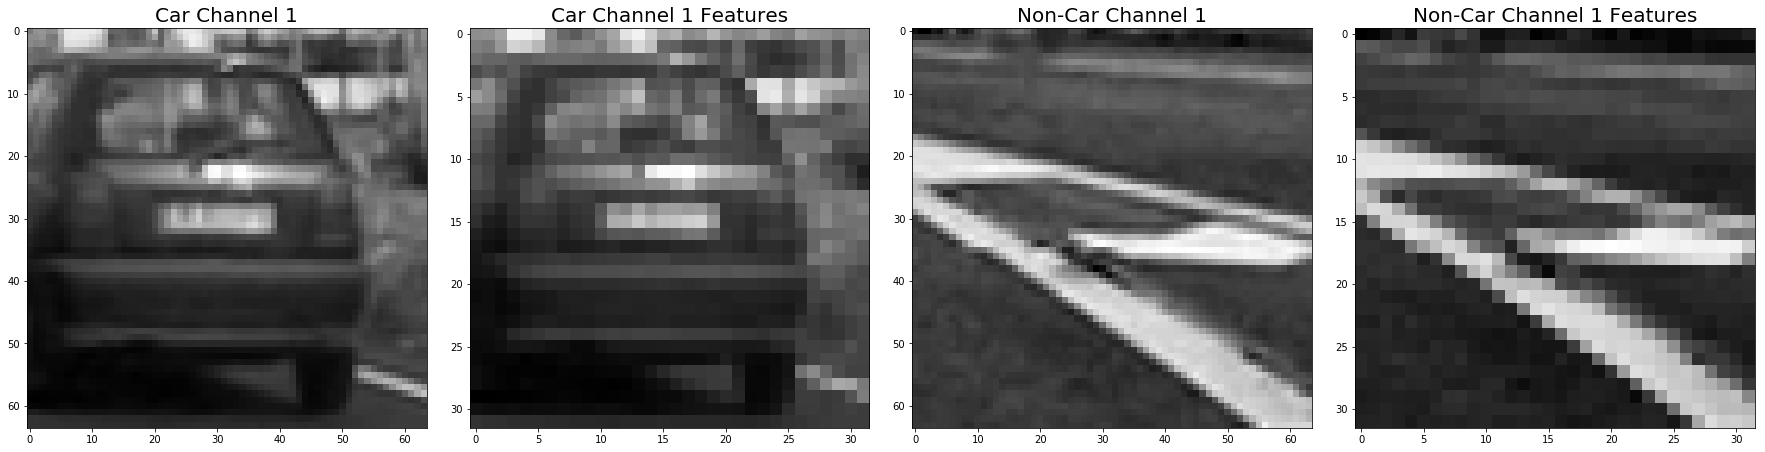

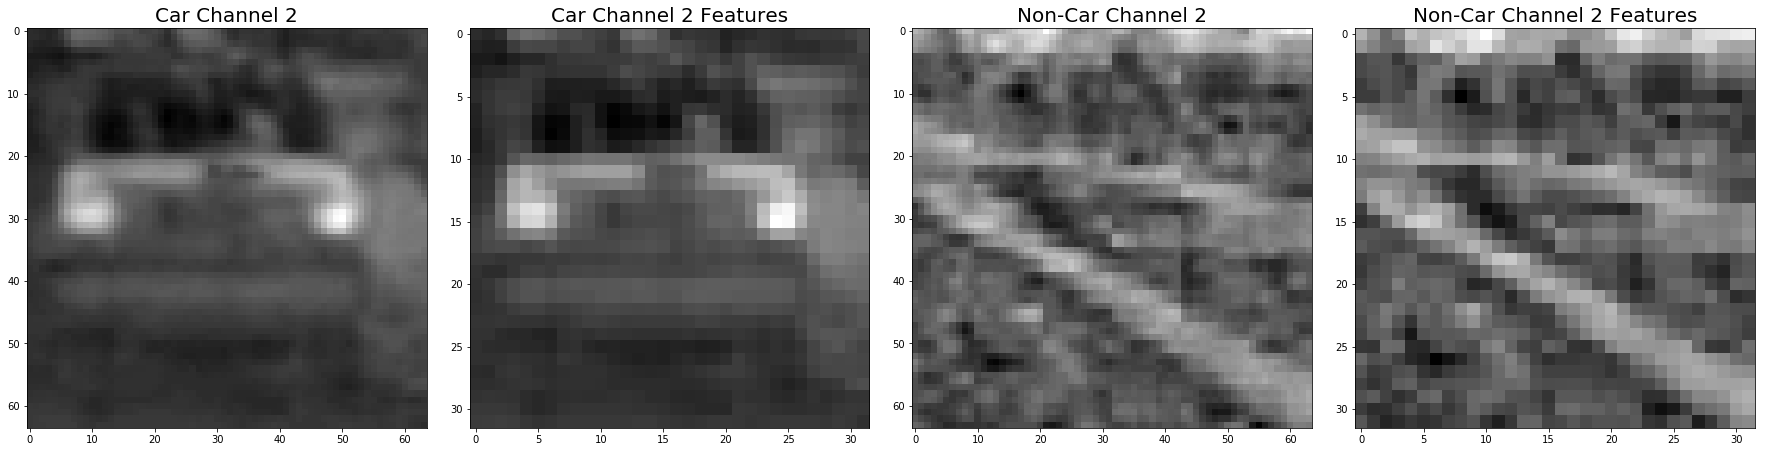

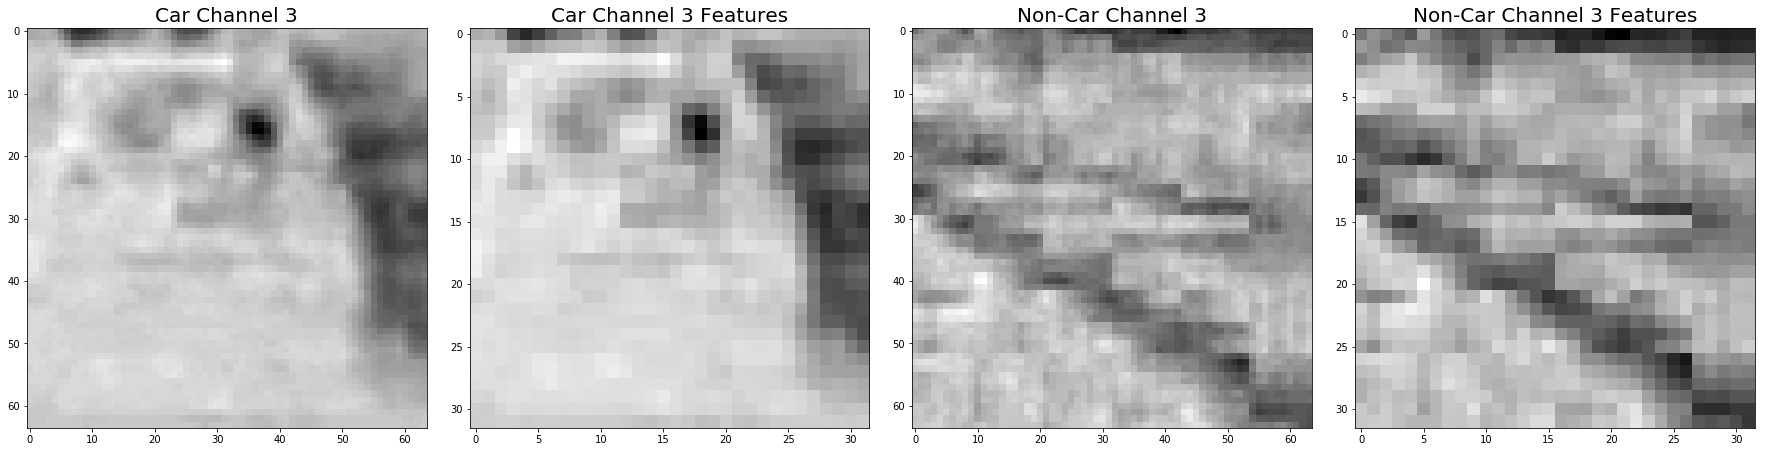

In [5]:
# Inspect the features of the channels
car_ch1_features = cv2.resize(car_ch1, feature_extractor.parameters.spatial.size)
car_ch2_features = cv2.resize(car_ch2, feature_extractor.parameters.spatial.size)
car_ch3_features = cv2.resize(car_ch3, feature_extractor.parameters.spatial.size)
noncar_ch1_features = cv2.resize(noncar_ch1, feature_extractor.parameters.spatial.size)
noncar_ch2_features = cv2.resize(noncar_ch2, feature_extractor.parameters.spatial.size)
noncar_ch3_features = cv2.resize(noncar_ch3, feature_extractor.parameters.spatial.size)

channel_1_spatial_images = [{'image': car_ch1,             'title': "Car Channel 1"}, \
                            {'image': car_ch1_features,    'title': "Car Channel 1 Features"}, \
                            {'image': noncar_ch1,          'title': "Non-Car Channel 1"}, \
                            {'image': noncar_ch1_features, 'title': "Non-Car Channel 1 Features"}]
feature_extractor.show_images_with_titles(channel_1_spatial_images)

channel_2_spatial_images = [{'image': car_ch2,             'title': "Car Channel 2"}, \
                            {'image': car_ch2_features,    'title': "Car Channel 2 Features"}, \
                            {'image': noncar_ch2,          'title': "Non-Car Channel 2"}, \
                            {'image': noncar_ch2_features, 'title': "Non-Car Channel 2 Features"}]
feature_extractor.show_images_with_titles(channel_2_spatial_images)

channel_3_spatial_images = [{'image': car_ch3,             'title': "Car Channel 3"}, \
                            {'image': car_ch3_features,    'title': "Car Channel 3 Features"}, \
                            {'image': noncar_ch3,          'title': "Non-Car Channel 3"}, \
                            {'image': noncar_ch3_features, 'title': "Non-Car Channel 3 Features"}]
feature_extractor.show_images_with_titles(channel_3_spatial_images) 

## Train the Image Classifier

In [6]:
# A helper class to classify images between cars and objects that are not cars
class CarClassifier:
    def __init__(self, car_images, noncar_images):
        # Use a linear SVC as the model for the image classification
        self.svc = LinearSVC()
        self.X_scaler = None
        
        # Training datasets
        self.car_images = car_images
        self.noncar_images = noncar_images
        
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        
        # Training report
        self.accuracy = 0
        self.training_time_in_seconds = 0
    
    # Determine whether the input image is a image of a car
    def is_car(self, image):
        transformed_image = self.X_scaler.transform(image)
        prediction = self.svc.predict(transformed_image)
        if (prediction == 1):
            return True
        else:
            return False
    
    # Train the image classifier
    def train(self):
        data_generation_start_time = time.time()
        self.generate_training_data()
        data_generation_end_time = time.time()
        self.data_generation_time_in_seconds = round(data_generation_end_time - data_generation_start_time, 2)
        
        training_start_time = time.time()
        self.svc.fit(self.X_train, self.y_train)
        training_end_time = time.time()
        self.training_time_in_seconds = round(training_end_time - training_start_time, 2)
        
        self.accuracy = round(self.svc.score(self.X_test, self.y_test), 4)
    
    # Generate the training data
    def generate_training_data(self):
        X = np.vstack((self.car_images, self.noncar_images)).astype(np.float64)    
        
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)
        
        # Define the labels vector
        y = np.hstack((np.ones(len(self.car_images)), np.zeros(len(self.noncar_images))))

        # Split up data into randomized training and test sets
        random_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = \
            train_test_split(scaled_X, y, test_size=0.2, random_state=random_state)
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    
    # Show the report of the training
    def report(self):
        print('SVC Training Report:')
        print('\tLenth of the Feature Vectors: {0}'.format(len(self.X_train[0])))
        print('\tData Generation Time: {0}(seconds)'.format(self.data_generation_time_in_seconds))
        print('\tTraining Time: {0}(seconds)'.format(self.training_time_in_seconds))
        print('\tTest Accuracy: {0}'.format(self.accuracy))

In [7]:
# Test the CarClassifier class
# 1. Prepare the training data
feature_extraction_start_time = time.time()
car_images = feature_extractor.extract_features(data_collector.cars)
noncar_images = feature_extractor.extract_features(data_collector.noncars)
feature_extraction_end_time = time.time()
feature_extraction_time_in_seconds = round(feature_extraction_end_time - feature_extraction_start_time, 2)

# 2. Show the report of the training data preparation
print('Feature Extraction Report:')
print('\tFeature Extraction Time: {0}(seconds)'.format(feature_extraction_time_in_seconds))
print('\tOrientations: {0}'.format(feature_extractor.parameters.hog.orientations))
print('\tPixels Per Cell: {0}'.format(feature_extractor.parameters.hog.pix_per_cell))
print('\tCells Per Block: {0}'.format(feature_extractor.parameters.hog.cell_per_block))
print('')

Feature Extraction Report:
	Feature Extraction Time: 15.05(seconds)
	Orientations: 15
	Pixels Per Cell: 8
	Cells Per Block: 2



In [8]:
# 3. Train the car classifier
car_classifier = CarClassifier(car_images, noncar_images)
car_classifier.train()

# 4. Show the report of the training
car_classifier.report()

SVC Training Report:
	Lenth of the Feature Vectors: 11988
	Data Generation Time: 2.23(seconds)
	Training Time: 1.27(seconds)
	Test Accuracy: 0.9873


## Car Detection

In [9]:
class CarDetector:
    def __init__(self, car_classifier, feature_extractor):
        self.car_classifier = car_classifier
        self.feature_extractor = feature_extractor
        
        self.search_boxes = [{'start_y': 400, 'stop_y': 500, 'scale': 1.0}, \
                             {'start_y': 400, 'stop_y': 500, 'scale': 1.3}, \
                             {'start_y': 410, 'stop_y': 500, 'scale': 1.4}, \
                             {'start_y': 420, 'stop_y': 556, 'scale': 1.6}, \
                             {'start_y': 430, 'stop_y': 556, 'scale': 1.8}, \
                             {'start_y': 430, 'stop_y': 556, 'scale': 2.0}, \
                             {'start_y': 440, 'stop_y': 556, 'scale': 1.9}, \
                             {'start_y': 400, 'stop_y': 556, 'scale': 1.3}, \
                             {'start_y': 400, 'stop_y': 556, 'scale': 2.2}, \
                             {'start_y': 500, 'stop_y': 656, 'scale': 3.0}]
    
    # Convert the image based on a color specification
    def convert_color(self, image, conversion='RGB2YCrCb'):
        if (conversion == 'RGB2YCrCb'):
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        if (conversion == 'BGR2YCrCb'):
            return cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        if (conversion == 'RGB2LUV'):
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        if (conversion == 'RGB2YUV'):
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    
    # Detect cars in the input image
    def detect_cars(self, img, ystart, ystop, scale, draw_boxes=False):
        if (draw_boxes):
            draw_img = np.copy(img)
        else:
            draw_img = img
        
        img = img.astype(np.float32)/255
        
        # Do sub-sampling
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = self.convert_color(img_tosearch, 'RGB2YUV')
        if (scale != 1):
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        pix_per_cell = self.feature_extractor.parameters.hog.pix_per_cell
        cell_per_block = self.feature_extractor.parameters.hog.cell_per_block
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = self.feature_extractor.parameters.hog.orientations*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = self.feature_extractor.get_hog_features(ch1, vis=False, feature_vec=False)
        hog2 = self.feature_extractor.get_hog_features(ch2, vis=False, feature_vec=False)
        hog3 = self.feature_extractor.get_hog_features(ch3, vis=False, feature_vec=False)
        
        bboxes = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                # Extract HOG for this patch
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
                # Extract the image patch
                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                
                # Get color features
                spatial_features = self.feature_extractor.get_spatial_image(subimg)
                hist_features = self.feature_extractor.get_color_histogram(subimg)
                
                # Scale features and make a prediction
                test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
                is_car = self.car_classifier.is_car(test_stacked)
                if (is_car):
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    
                    bboxes.append(((int(xbox_left), int(ytop_draw+ystart)), \
                                   (int(xbox_left+win_draw), int(ytop_draw+win_draw+ystart))))
                    
                    if (draw_boxes):
                        cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), \
                                      (xbox_left+win_draw, ytop_draw+win_draw+ystart), \
                                      (0,0,255), 4)
        
        return draw_img, bboxes
    
    # Detect cars with search boxes
    def detect_with_search_boxes(self, image, draw_boxes=False):
        search_image = image
        bboxes = []
        for index, search_box in enumerate(self.search_boxes):
            search_image, bboxes_from_cars = self.detect_cars(search_image, search_box['start_y'], \
                search_box['stop_y'], search_box['scale'], draw_boxes)
            bboxes.extend(bboxes_from_cars)
        
        return search_image, bboxes

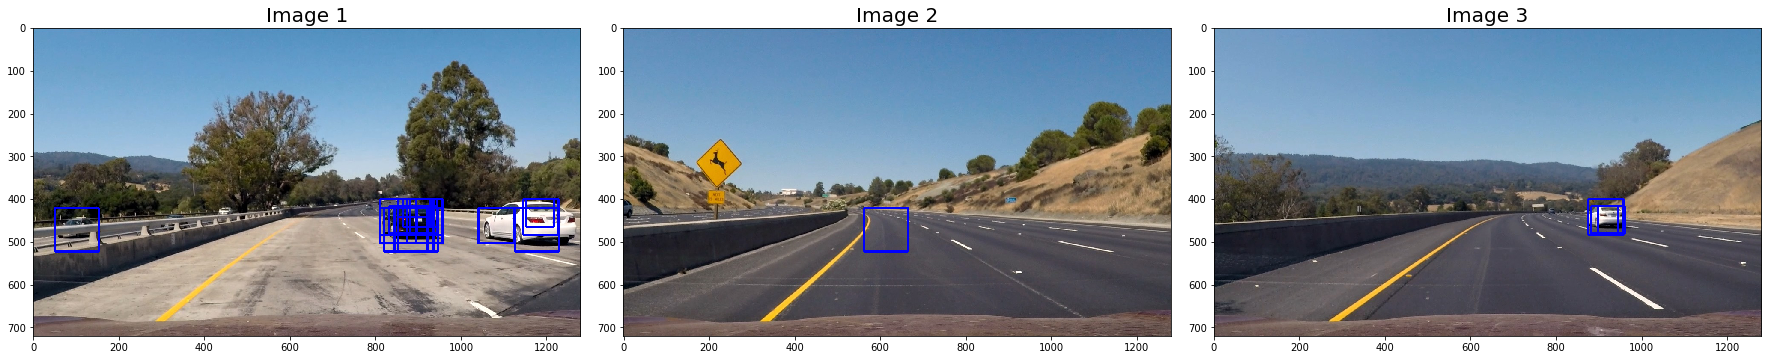

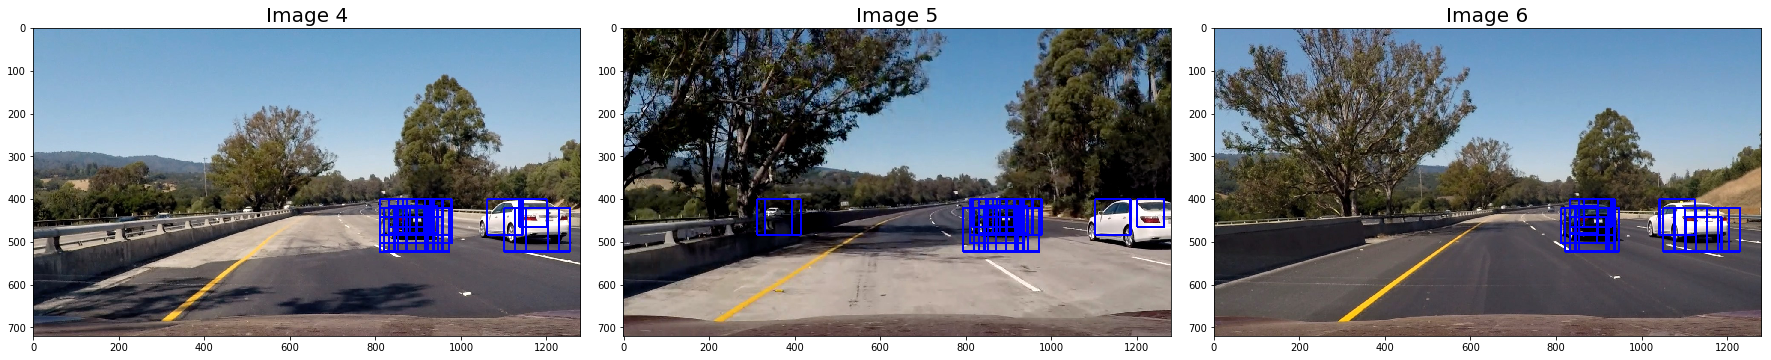

In [10]:
# Test the CarDetector class
image1 = mpimg.imread('./test_images/test1.jpg')
image2 = mpimg.imread('./test_images/test2.jpg')
image3 = mpimg.imread('./test_images/test3.jpg')
image4 = mpimg.imread('./test_images/test4.jpg')
image5 = mpimg.imread('./test_images/test5.jpg')
image6 = mpimg.imread('./test_images/test6.jpg')

car_detector = CarDetector(car_classifier, feature_extractor)

draw_boxes=True
output_image1, bboxes1 = car_detector.detect_with_search_boxes(image1, draw_boxes)
output_image2, bboxes2 = car_detector.detect_with_search_boxes(image2, draw_boxes)
output_image3, bboxes3 = car_detector.detect_with_search_boxes(image3, draw_boxes)
output_image4, bboxes4 = car_detector.detect_with_search_boxes(image4, draw_boxes)
output_image5, bboxes5 = car_detector.detect_with_search_boxes(image5, draw_boxes)
output_image6, bboxes6 = car_detector.detect_with_search_boxes(image6, draw_boxes)

output_images = [{'image': output_image1, 'title': "Image 1"}, \
                 {'image': output_image2, 'title': "Image 2"}, \
                 {'image': output_image3, 'title': "Image 3"}]
car_detector.feature_extractor.show_images_with_titles(output_images)

output_images = [{'image': output_image4, 'title': "Image 4"}, \
                 {'image': output_image5, 'title': "Image 5"}, \
                 {'image': output_image6, 'title': "Image 6"}]
car_detector.feature_extractor.show_images_with_titles(output_images)

## Heat Detection

In [11]:
# A helper class to detect heat from a image with boxes
class HeatDetector:
    def __init__(self):
        self.threshold = 1
    
    # Add heat to the heatmap
    def add_heat(self, heatmap, bbox_list):
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
        # Return updated heatmap
        return heatmap
    
    # Apply the threshold to the heatmap
    def apply_threshold(self, heatmap):
        # Zero out pixels below the threshold
        heatmap[heatmap <= self.threshold] = 0
        
        # Return thresholded map
        return heatmap
    
    # Draw labeled boxes
    def draw_labeled_bboxes(self, image_to_draw, labels):
        # Process each detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            # Define a bounding box based on min/max x and y
            bounding_box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            # Draw the box on the image
            cv2.rectangle(image_to_draw, bounding_box[0], bounding_box[1], (0,255,0), 4)
        
        return image_to_draw
    
    # Get the heatmap from the boxes
    def get_heatmap(self, image, bboxes):
        heat = np.zeros_like(image[:, :, 0]).astype(np.float) 
        heat = self.add_heat(heat, bboxes)
        heat = self.apply_threshold(heat)
        heatmap = np.clip(heat, 0, 255)
        return heat, heatmap
    
    # Show the images with titles
    def show_images(self, image_cars_in_boxes, image_heat_detection, \
                    image1_title="Cars in Detecting Boxes", image2_title="Heat Detection", \
                    figsize=(16, 6)):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        f.tight_layout()
        
        ax1.imshow(image_cars_in_boxes)
        ax1.set_title(image1_title, fontsize=16)
        
        ax2.imshow(image_heat_detection, cmap='hot')
        ax2.set_title(image2_title, fontsize=16)
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

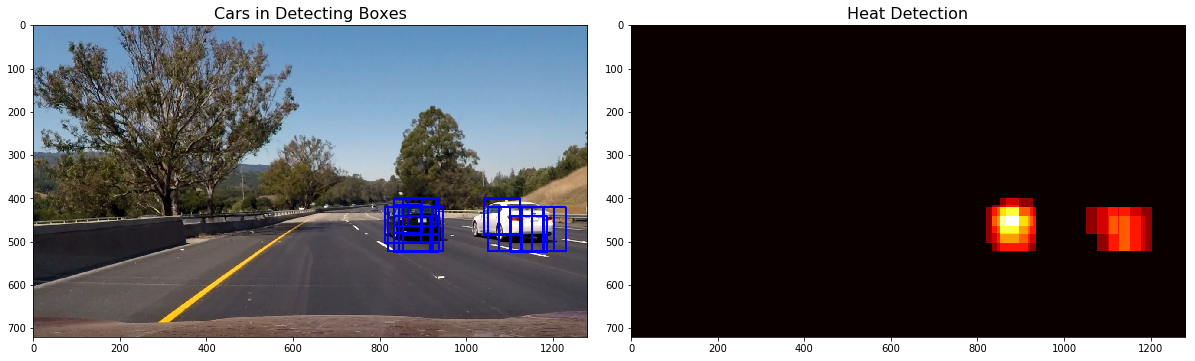

In [12]:
# Test the HeatDetector class
heat_detector = HeatDetector()

image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)
output_image, bboxes = car_detector.detect_with_search_boxes(image, draw_boxes)
_, heatmap = heat_detector.get_heatmap(output_image, bboxes)
heat_detector.show_images(output_image, heatmap)

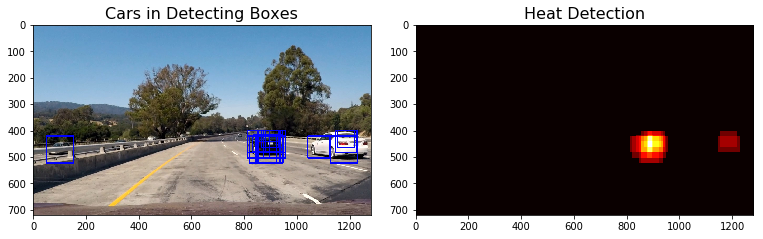

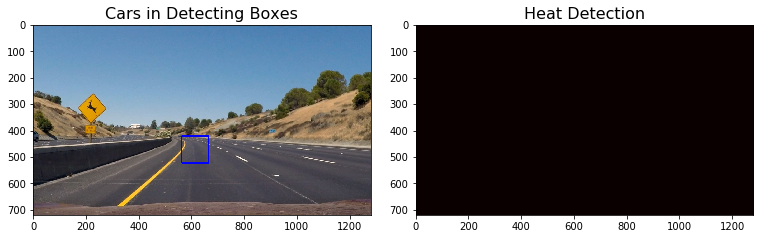

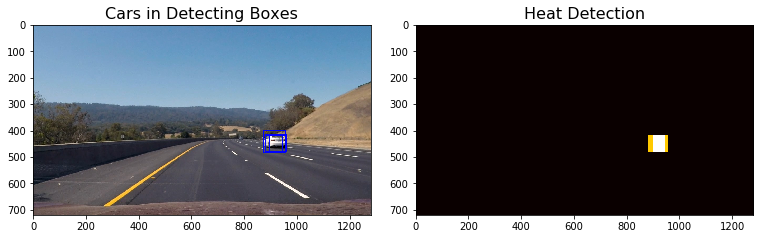

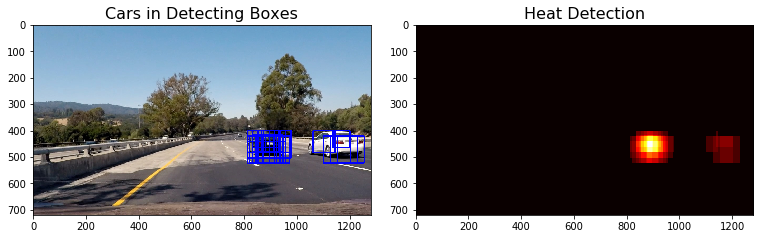

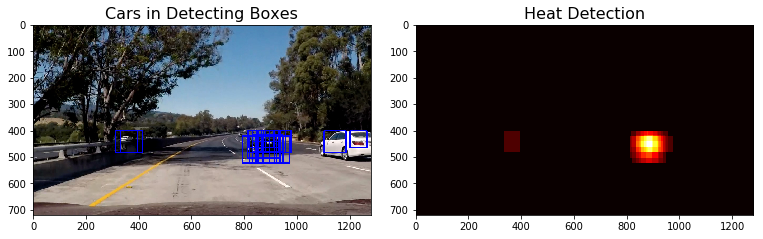

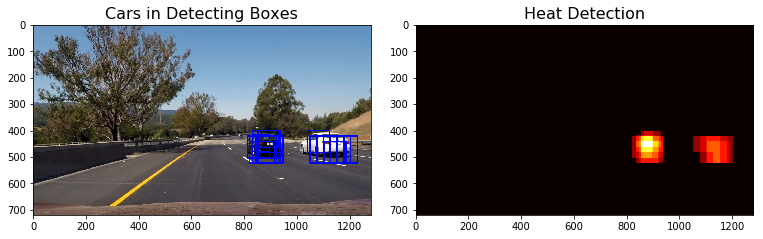

In [13]:
# Test the HeatDetector class with more images
_, heatmap1 = heat_detector.get_heatmap(output_image1, bboxes1)
_, heatmap2 = heat_detector.get_heatmap(output_image2, bboxes2)
_, heatmap3 = heat_detector.get_heatmap(output_image3, bboxes3)
_, heatmap4 = heat_detector.get_heatmap(output_image4, bboxes4)
_, heatmap5 = heat_detector.get_heatmap(output_image5, bboxes5)
_, heatmap6 = heat_detector.get_heatmap(output_image6, bboxes6)

fig_size=(10, 4)
heat_detector.show_images(output_image1, heatmap1, figsize=fig_size)
heat_detector.show_images(output_image2, heatmap2, figsize=fig_size)
heat_detector.show_images(output_image3, heatmap3, figsize=fig_size)
heat_detector.show_images(output_image4, heatmap4, figsize=fig_size)
heat_detector.show_images(output_image5, heatmap5, figsize=fig_size)
heat_detector.show_images(output_image6, heatmap6, figsize=fig_size)

### Labeled Image with Final Detection Box

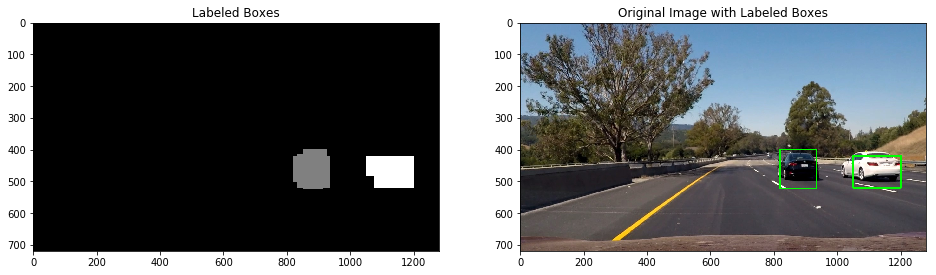

In [14]:
# Test the HeatDetector class with labeled boxes
labels = label(heatmap)
image_with_labeled_boxes = heat_detector.draw_labeled_bboxes(np.copy(image), labels)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("Labeled Boxes")
plt.imshow(labels[0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Original Image with Labeled Boxes")
plt.imshow(image_with_labeled_boxes)
plt.show()

## Video Pipline
### The Image Processor

In [15]:
# The global list of heat
global_heat_history = deque(maxlen = 8)

# The image processor for producing videos
def image_processor(image):
    _, bboxes = car_detector.detect_with_search_boxes(image)
    
    # Visualize the heatmap when displaying    
    heat, current_heatmap = heat_detector.get_heatmap(image, bboxes)
    global_heat_history.append(current_heatmap)
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in global_heat_history:
        heatmap = heatmap + heat
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    image_with_heated_boxes = heat_detector.draw_labeled_bboxes(np.copy(image), labels)
    return image_with_heated_boxes

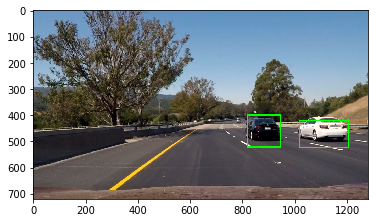

In [16]:
# Test the image processor
output_image_from_processor = image_processor(image)
plt.imshow(output_image_from_processor)
plt.show()

### Produce Videos

In [17]:
global_heat_history = deque(maxlen = 8)

test_video_output_file = 'test_video_output.mp4'
test_video_output_clip = VideoFileClip("test_video.mp4")
test_video_output = test_video_output_clip.fl_image(image_processor)
%time test_video_output.write_videofile(test_video_output_file, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:32<00:00,  1.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 31.3 s, sys: 1.38 s, total: 32.6 s
Wall time: 32.9 s


In [18]:
global_heat_history = deque(maxlen = 8)

project_video_output_file = 'project_video_output.mp4'
project_video_output_clip = VideoFileClip("project_video.mp4")
project_video_output = project_video_output_clip.fl_image(image_processor)
%time project_video_output.write_videofile(project_video_output_file, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [17:22<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 16min 59s, sys: 38.3 s, total: 17min 38s
Wall time: 17min 23s
